In [14]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [8]:
def get_valid(file_path):
    correct_files = []
    for name in os.listdir(file_path):
        try:
            img = Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

In [9]:
local_zip = 'kagglecatsanddogs_5340.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
classes = ['Cat', 'Dog']
original_cat_path = '/tmp/PetImages/Cat'
original_dog_path = '/tmp/PetImages/Dog'
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)
random.seed(101)

random.shuffle(original_cat)
random.shuffle(original_dog)
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))

valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'
index = 0

for name_cat, name_dog in zip(original_cat, original_dog):
        if index <= train_size:
            type_of_dataset = 'train'
        elif train_size < index <= (train_size + valid_size):
            type_of_dataset = 'valid'
        elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
            type_of_dataset = 'test'
        shutil.copyfile(src=(original_cat_path + '/' +name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
        shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
        index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

D:\ML_AI\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


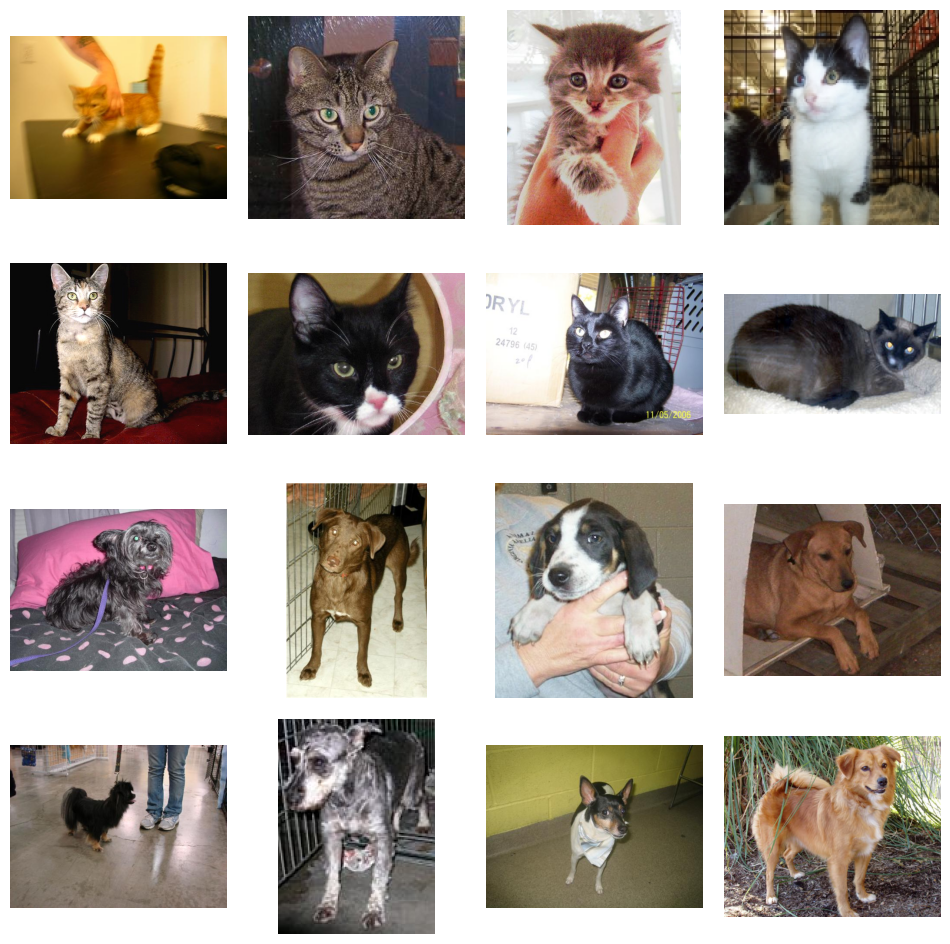

In [10]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [11]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [12]:
models = []
os.mkdir("history")
os.mkdir("charts")

In [15]:
model_baseline = Sequential()
model_baseline.add(Input(shape=(150, 150, 3)))
model_baseline.add(Flatten())
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        67,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,501 (263.68 KB)

 Trainable params: 67,501 (263.68 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [19]:
history_baseline = model_baseline.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5087 - loss: 0.9830 - val_accuracy: 0.5136 - val_loss: 0.7355
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5218 - loss: 0.9142 - val_accuracy: 0.5116 - val_loss: 0.7700
Epoch 3/1000
  1/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 0.7496

D:\ML_AI\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5547 - loss: 0.8741 - val_accuracy: 0.4964 - val_loss: 1.0116
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5193 - loss: 0.9258 - val_accuracy: 0.5084 - val_loss: 0.9125
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.5151 - loss: 0.9310 - val_accuracy: 0.4984 - val_loss: 1.0778
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5312 - loss: 1.0383 - val_accuracy: 0.5569 - val_loss: 0.7123
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5256 - loss: 0.9107 - val_accuracy: 0.5016 - val_loss: 0.9644
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5361 - loss: 0.9085 - val_accuracy: 0.4940 - val_loss: 1.1627
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5391 - loss: 0.8503 - val_accuracy: 0.5036 - val_loss: 0.9434
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5318 - loss: 0.9088 - val_

In [34]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'history/history_model_4.csv'

In [22]:
model_simple_1 = Sequential()
model_simple_1.add(Input(shape=(150, 150, 3)))
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu'))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 54760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        54,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,041 (215.00 KB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history_simple_1 = model_simple_1.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
 46/136 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.4795 - loss: 1.2031

D:\ML_AI\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.5844 - loss: 0.7300 - val_accuracy: 0.6651 - val_loss: 0.6087
Epoch 2/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6897 - loss: 0.5857 - val_accuracy: 0.7043 - val_loss: 0.5707
Epoch 3/1000
  1/136 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6875 - loss: 0.5545

D:\ML_AI\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6953 - loss: 0.5615 - val_accuracy: 0.7023 - val_loss: 0.5707
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7238 - loss: 0.5515 - val_accuracy: 0.7139 - val_loss: 0.5729
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7469 - loss: 0.5153 - val_accuracy: 0.7143 - val_loss: 0.5555
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8125 - loss: 0.4140 - val_accuracy: 0.7288 - val_loss: 0.5576
Epoch 7/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7692 - loss: 0.4885 - val_accuracy: 0.7328 - val_loss: 0.5468
Epoch 8/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7818 - loss: 0.4710 - val_accuracy: 0.7272 - val_loss: 0.5495
Epoch 9/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7969 - loss: 0.4559 - val_accuracy: 0.7364 - val_loss: 0.5273
Epoch 10/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8023 - loss: 0.4394 -

In [33]:
model_simple_2 = Sequential()
model_simple_2.add(Input(shape=(150, 150, 3)))
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu'))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")
history_simple_2 = model_simple_2.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_2_df = pd.DataFrame(history_simple_2.history)
history_simple_2_csv_file = 'history/history_simple_2.csv'

with open(history_simple_2_csv_file, mode='w') as f:
    history_simple_2_df.to_csv(f)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 56250)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │        56,251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,531 (220.82 KB)

 Trainable params: 56,531 (220.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6044 - loss: 0.6852 - val_accuracy: 0.6987 - val_loss: 0.6017
Epoch 2/1000
 87/136 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6969 - loss: 0.5940

D:\ML_AI\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7070 - loss: 0.5750 - val_accuracy: 0.7107 - val_loss: 0.5641
Epoch 3/1000
  1/136 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6719 - loss: 0.5594

D:\ML_AI\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7734 - loss: 0.4896 - val_accuracy: 0.7200 - val_loss: 0.5753
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7253 - loss: 0.5438 - val_accuracy: 0.7115 - val_loss: 0.5627
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.7657 - loss: 0.4957 - val_accuracy: 0.7107 - val_loss: 0.5585


In [31]:
from tensorflow.keras.applications import VGG16
import keras.optimizers

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                       optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                       metrics=['accuracy'])
model_4.summary()
models.append("model_4")

layer_name: input_layer_12 trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 9,209,857 (35.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [35]:
history_4 = model_4.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_4_df = pd.DataFrame(history_4.history)
history_4_csv_file = 'history/history_simple_4.csv'

with open(history_4_csv_file, mode='w') as f:
    history_4_df.to_csv(f)

Epoch 1/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8428 - loss: 0.3368 - val_accuracy: 0.9335 - val_loss: 0.1722
Epoch 2/1000
118/136 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9231 - loss: 0.1971

D:\ML_AI\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9278 - loss: 0.1832 - val_accuracy: 0.9399 - val_loss: 0.1553
Epoch 3/1000
  2/136 ━━━━━━━━━━━━━━━━━━━━ 2:35 1s/step - accuracy: 0.9102 - loss: 0.1755

D:\ML_AI\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 301ms/step - accuracy: 0.9297 - loss: 0.1440 - val_accuracy: 0.9295 - val_loss: 0.1672
Epoch 4/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9434 - loss: 0.1338 - val_accuracy: 0.9531 - val_loss: 0.1274
Epoch 5/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9547 - loss: 0.1120 - val_accuracy: 0.9551 - val_loss: 0.1164
Epoch 6/1000
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.9688 - loss: 0.0896 - val_accuracy: 0.9531 - val_loss: 0.1271
Epoch 7/1000
 37/136 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.9726 - loss: 0.0819

KeyboardInterrupt: 